In [1]:
from langchain.chains import ConversationalRetrievalChain
from langchain.prompts import PromptTemplate
from langchain.vectorstores import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_huggingface import HuggingFacePipeline
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

# Initialize the LLM pipeline
model_name = "microsoft/Phi-3.5-mini-instruct"
model = AutoModelForCausalLM.from_pretrained(
    model_name, 
    device_map="cuda", 
    torch_dtype="auto", 
    trust_remote_code=True, 
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
hf_pipeline = pipeline("text-generation", model=model, tokenizer=tokenizer, max_new_tokens=500)
llm = HuggingFacePipeline(pipeline=hf_pipeline)

from langchain_core.prompts import PromptTemplate

template = """Question: {question}

Answer: Let's think step by step."""
prompt = PromptTemplate.from_template(template)

chain = prompt | llm

question = "What is electroencephalography?"

print(chain.invoke({"question": question}))

`flash-attention` package not found, consider installing for better performance: No module named 'flash_attn'.
Current `flash-attention` does not support `window_size`. Either upgrade or use `attn_implementation='eager'`.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda
The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
`get_max_cache()` is deprecated for all Cache classes. Use `get_max_cache_shape()` instead. Calling `get_max_cache()` will raise error from v4.48
You are not running the flash-attention implementation, expect numerical differences.


Question: What is electroencephalography?

Answer: Let's think step by step.

Step 1: Understand the term "electroencephalography"
Electroencephalography (EEG) is a medical test that measures the electrical activity of the brain. It involves placing small electrodes on the scalp to detect and record the brain's electrical signals.

Step 2: Break down the term into its components
- "Electro" refers to the electrical aspect of the test.
- "Encephalography" refers to the study or recording of the brain.

Step 3: Combine the components to form the definition
Electroencephalography is a medical test that measures the electrical activity of the brain by placing small electrodes on the scalp to detect and record the brain's electrical signals.

Answer: Electroencephalography is a medical test that measures the electrical activity of the brain by placing small electrodes on the scalp to detect and record the brain's electrical signals.


In [1]:
import bs4
from langchain import hub
from langchain_chroma import Chroma
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings, HuggingFacePipeline
from langchain.prompts import PromptTemplate

from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

# Initialize the LLM pipeline
model_name = "meta-llama/Llama-3.2-3B-Instruct"
# model_name = "microsoft/Phi-3.5-mini-instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name, 
    device_map="cuda", 
    torch_dtype="auto", 
    # trust_remote_code=True, 
    eos_token_id=tokenizer.eos_token_id
)


hf_pipeline = pipeline("text-generation", model=model, tokenizer=tokenizer,
                       max_new_tokens=500,
                       return_full_text= False,
                       temperature=0.0, do_sample=False)
llm = HuggingFacePipeline(pipeline=hf_pipeline)

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
vectorstore = Chroma.from_documents(collection_name='test', documents=splits, embedding=embeddings)

# Retrieve and generate using the relevant snippets of the blog.
retriever = vectorstore.as_retriever()
qna_prompt_template="""<|system|>
You have been provided with the context and a question, try to find out the answer to the question only using the context information. If the answer to the question is not found within the context, return "I dont know" as the response.<|end|>
<|user|>
Context:
{context}

Question: {question}<|end|>
<|assistant|>"""
prompt = PromptTemplate(
   template=qna_prompt_template, input_variables=["context", "question"]
)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

USER_AGENT environment variable not set, consider setting it to identify your requests.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda


In [2]:
question = "What is Task Decomposition?"
for chunk in rag_chain.stream(question):
    print(chunk, end="", flush=True)

/home/ellis/.cache/pypoetry/virtualenvs/shoptalk-py3-12-PgppYsjg-py3.12/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/ellis/.cache/pypoetry/virtualenvs/shoptalk-py3-12-PgppYsjg-py3.12/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Task decomposition is the process of breaking down a complex task into smaller, more manageable subtasks. In the context of Tree of Thoughts, task decomposition is done by decomposing the problem into multiple thought steps and generating multiple thoughts per step, creating a tree structure. This process can be done using LLM with simple prompting, task-specific instructions, or human inputs.

In [1]:
import bs4
from langchain_community.document_loaders import WebBaseLoader
from langchain_huggingface import HuggingFaceEmbeddings, HuggingFacePipeline
from langchain.vectorstores import Chroma
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import PromptTemplate

tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3.5-mini-instruct")
model = AutoModelForCausalLM.from_pretrained("microsoft/Phi-3.5-mini-instruct", device_map='cuda', torch_dtype="auto", trust_remote_code=True,)

pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, max_new_tokens=500)
llm = HuggingFacePipeline(pipeline=pipe)

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
vectorstore = Chroma.from_documents(collection_name='test', documents=splits, embedding=embeddings, persist_directory='/mnt/d/db')
retriever = vectorstore.as_retriever(search_kwargs = {"k": 3})

# Define the custom prompt template suitable for the Phi-3 model
qna_prompt_template="""<|system|>
You have been provided with the context and a question, try to find out the answer to the question only using the context information. If the answer to the question is not found within the context, return "I dont know" as the response.<|end|>
<|user|>
Context:
{context}

Question: {question}<|end|>
<|assistant|>"""
prompt = PromptTemplate(
   template=qna_prompt_template, input_variables=["context", "question"]
)

# Define the QNA chain
chain = create_stuff_documents_chain(llm, prompt=prompt)

# A utility function for answer generation
def ask(question):
   context = retriever.invoke(question)
   answer = chain.stream({"context": context, "question": question})
   return answer

USER_AGENT environment variable not set, consider setting it to identify your requests.
`flash-attention` package not found, consider installing for better performance: No module named 'flash_attn'.
Current `flash-attention` does not support `window_size`. Either upgrade or use `attn_implementation='eager'`.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda


In [ ]:
user_question = "What is Task Decomposition?"
for chunk in ask(user_question):
    print(chunk, end="", flush=True)

The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
`get_max_cache()` is deprecated for all Cache classes. Use `get_max_cache_shape()` instead. Calling `get_max_cache()` will raise error from v4.48
You are not running the flash-attention implementation, expect numerical differences.


Task decomposition, as described in the context, refers to the process of breaking down a complex problem into smaller, more manageable sub-tasks or thought steps. This can be achieved through:

1. Using Large Language Models (LLMs) with simple prompting, where the user provides instructions like "Steps for XYZ." or "What are the subgoals for achieving XYZ?"
2. Employing task-specific instructions, such as "Write a story outline." for writing a novel.
3. Incorporating human inputs to guide the decomposition process.

The goal of task decomposition is to create a tree structure of multiple thoughts per step, which can then be explored using search methods like BFS (breadth-first search) or DFS (depth-first search). Each state within the tree can be evaluated by a classifier (via a prompt) or majority vote. This approach allows for a more comprehensive exploration of multiple reasoning possibilities at each step.

Streaming working with LangGraph (need to wrap LLM inside LangChain inside LangGraph). Doesn't allow for further modifications with agents and/or memory.

In [1]:
import bs4
from langchain_community.document_loaders import WebBaseLoader
from langchain_huggingface import HuggingFaceEmbeddings, HuggingFacePipeline
from langchain.vectorstores import Chroma
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langgraph.graph import StateGraph, END
from typing import Dict, TypedDict, Annotated
from typing_extensions import TypedDict
from langchain.chains.combine_documents import create_stuff_documents_chain

# --- (1) Model and Embedding Initialization ---
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3.5-mini-instruct")
model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3.5-mini-instruct",
    device_map="cuda",
    torch_dtype="auto",
    trust_remote_code=True,
)

pipe = pipeline(
    "text-generation", model=model, tokenizer=tokenizer, max_new_tokens=500
)
llm = HuggingFacePipeline(pipeline=pipe)

embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-mpnet-base-v2"
)

# --- (2) Data Loading and Vector Store Setup ---
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
vectorstore = Chroma.from_documents(
    collection_name="test",
    documents=splits,
    embedding=embeddings,
    persist_directory="/mnt/d/db",
)
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

# --- (3) Prompt Template and Document Chain ---
qna_prompt_template = """<|system|>
You have been provided with the context and a question, try to find out the answer to the question only using the context information. If the answer to the question is not found within the context, return "I dont know" as the response.<|end|>
<|user|>
Context:
{context}

Question: {question}<|end|>
<|assistant|>"""
prompt = PromptTemplate(
    template=qna_prompt_template, input_variables=["context", "question"]
)

# Create the document chain inside the LangGraph
chain = create_stuff_documents_chain(llm, prompt)

# --- (4) Define State ---
class GraphState(TypedDict):
    question: str
    context: Annotated[str, "context"]
    answer: str

# --- (5) Define Nodes ---
def retrieve_context(state):
    question = state["question"]
    context = retriever.invoke(question)
    return {"context": context}

def generate_answer(state):
    context = state["context"]
    question = state["question"]
    # Use the chain inside the node function
    answer = chain.invoke({"context": context, "question": question})
    return {"answer": answer}

def generate_answer_stream(state):
    context = state["context"]
    question = state["question"]
    # Use the chain inside the node function and get the stream
    answer_stream = chain.stream({"context": context, "question": question})
    return {"answer": answer_stream}

# --- (6) Build Graph ---
workflow = StateGraph(GraphState)
workflow.add_node("retrieve", retrieve_context)
workflow.add_node("generate", generate_answer_stream)
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "generate")
workflow.add_edge("generate", END)

# --- (7) Compile and Run ---
app = workflow.compile()

USER_AGENT environment variable not set, consider setting it to identify your requests.
`flash-attention` package not found, consider installing for better performance: No module named 'flash_attn'.
Current `flash-attention` does not support `window_size`. Either upgrade or use `attn_implementation='eager'`.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda


In [2]:
user_question = "What is Task Decomposition?"
inputs = {"question": user_question}

# Iterate through the stream from app.stream()
for output in app.stream(inputs):
    # The output is a dictionary where the keys are node names
    for key, value in output.items():
        # Check if the node is the 'generate' node and stream its output
        if key == "generate":
            # Stream the output from the 'answer' generator
            for token in value["answer"]:  # Iterate over the stream generator
                print(token, end="", flush=True)
        else:
            print(f"{key}: {value}")
    print()  # New line for better readability

The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
`get_max_cache()` is deprecated for all Cache classes. Use `get_max_cache_shape()` instead. Calling `get_max_cache()` will raise error from v4.48
You are not running the flash-attention implementation, expect numerical differences.


retrieve: {'context': [Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.\nTask decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.'), Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes 

In [ ]:
import bs4
from langchain_huggingface import HuggingFaceEmbeddings, HuggingFacePipeline
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from typing_extensions import List, TypedDict
from typing import Annotated
from langchain_core.prompts import PromptTemplate
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, TextIteratorStreamer
from langchain_ollama import ChatOllama

model_name = "phi3.5:3.8b-mini-instruct-fp16"
# model_name = "llama3.2:3b-instruct-fp16"
llm = ChatOllama(model = model_name)

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
vectorstore = Chroma.from_documents(collection_name='test', documents=splits, embedding=embeddings, persist_directory='/mnt/d/db')
retriever = vectorstore.as_retriever(search_kwargs = {"k": 3})

# Define prompt for question-answering
qna_prompt_template="""<|system|>
You have been provided with the context and a question, try to find out the answer to the question only using the context information. If the answer to the question is not found within the context, return "I dont know" as the response.<|end|>
<|user|>
Context:
{context}

Question: {question}<|end|>
<|assistant|>"""
prompt = PromptTemplate(
   template=qna_prompt_template, input_variables=["context", "question"]
)


# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str
    messages: Annotated[list, add_messages]


# Define application steps
def retrieve(state: State):
    retrieved_docs = retriever.invoke(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

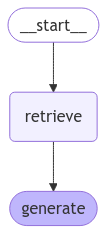

In [6]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
for message, metadata in graph.stream({"question": "What is Task Decomposition?"}, stream_mode="messages"):
    print(message.content, end="", flush=True)

Task decomposition refers to the process of breaking down a complex problem into smaller, more manageable sub-tasks or steps that can be addressed individually. In the context provided by Yao et al. (2023), task decomposition for Tree of Thoughts is achieved through different methods: using language model prompts like "Steps for XYZ.\n1." to outline problem-solving stages, employing specific instructions tailored to tasks such as writing an article or storyline ("Write a story outline."), and integrating human inputs into the process. This approach facilitates exploring multiple reasoning possibilities at each step by creating a tree structure of thoughts during task resolution using either BFS (breadth-first search) or DFS (depth-first search).